### Import libs

In [172]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs

### Read dataset

In [2]:
data_adsmart = pd.read_csv("AdSmartABdata.csv")

Dataset shape

In [3]:
data_adsmart.shape

(8077, 9)

Dataset samples

In [4]:
data_adsmart.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


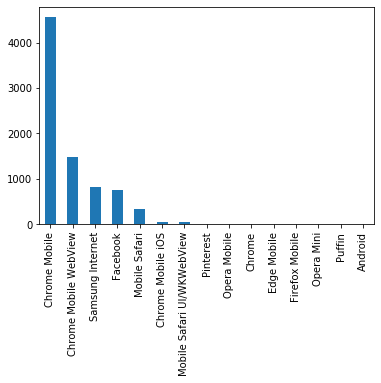

In [23]:
data_adsmart['browser'].value_counts().plot.bar()

## TODO descriptions

In [117]:
data_adsmart_clean = data_adsmart.drop(['auction_id', 'date', 'hour', 'device_make', 'platform_os', 'browser'], axis=1)
data_adsmart_clean = data_adsmart_clean[(data_adsmart_clean['yes'] != 0) | data_adsmart_clean['no'] != 0]
data_adsmart_clean['aware'] = 0
data_adsmart_clean.loc[data_adsmart_clean['yes'] == 1, 'aware'] = 1
data_adsmart_clean.loc[data_adsmart_clean['yes'] == 0, 'aware'] = 0

data_adsmart_clean

,experiment,yes,no,aware
2,exposed,0,1,0
16,exposed,1,0,1
20,exposed,0,1,0
23,control,1,0,1
27,control,0,1,0
...,...,...,...,...
8059,exposed,1,0,1
8063,exposed,1,0,1
8064,control,0,1,0
8069,control,0,1,0


In [121]:
ad_summary = data_adsmart_clean.pivot_table(values='aware', index='experiment', aggfunc=np.sum)

ad_summary['total'] = data_adsmart_clean.pivot_table(values='aware', index='experiment', aggfunc=lambda x: len(x))
ad_summary['rate'] = data_adsmart_clean.pivot_table(values='aware', index='experiment')
ad_summary

,aware,total,rate
experiment,,,
control,264,586,0.450512
exposed,308,657,0.468798


There is a 1.8% difference in conversion rates between the two groups. It is a good sign but this is not enough evidence for us to confidently go with the new design.

# Comparing the two groups

In [137]:
# data_binom = binom.rvs(n=10,p=0.8,size=10000)
e_aware = ad_summary['aware']['exposed']
e_total = ad_summary['total']['exposed']
e_rate = ad_summary['rate']['exposed']

c_aware = ad_summary['aware']['control']
c_total = ad_summary['total']['control']
c_rate = ad_summary['rate']['control']

d_cr = e_rate - c_rate

Text(0, 0.5, 'probability')

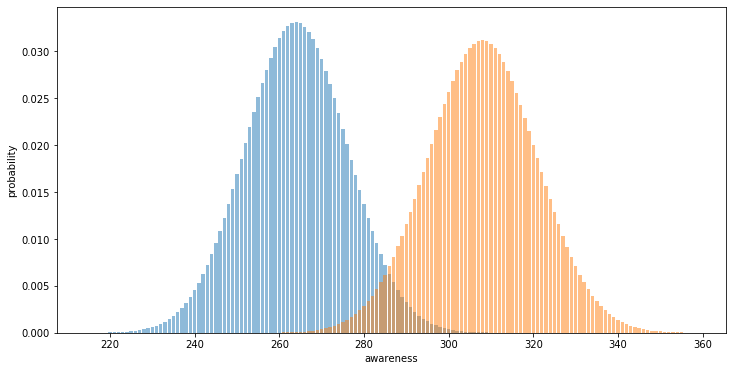

In [164]:
fig, ax = plt.subplots(figsize=(12,6))

xC = np.linspace(c_aware - 49, c_aware + 50, 100)
yC = binom(c_total, c_rate).pmf(xC)
ax.bar(xC, yC, alpha=0.5)

xE = np.linspace(e_aware - 49, e_aware + 50, 100)
yE = binom(e_total, e_rate).pmf(xE)
ax.bar(xE, yE, alpha=0.5)

plt.xlabel('awareness')
plt.ylabel('probability')

### Expresing the two binomila distribution as a normal distribution

Text(0, 0.5, 'PDF')

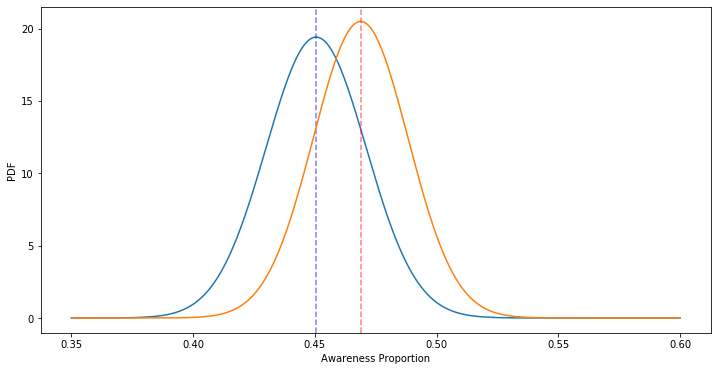

In [159]:
# standard error of the mean for both groups
SE_C = np.sqrt(c_rate * (1-c_rate)) / np.sqrt(c_total)
SE_E = np.sqrt(e_rate * (1-e_rate)) / np.sqrt(e_total)

# plot the null and alternative hypothesis
fig, ax = plt.subplots(figsize=(12,6))

x = np.linspace(.35, .6, 1000)

yC = scs.norm(c_rate, SE_C).pdf(x)
ax.plot(x, yC)
ax.axvline(x=c_rate, c='blue', alpha=0.5, linestyle='--')

yE = scs.norm(e_rate, SE_E).pdf(x)
ax.plot(x, yE)
ax.axvline(x=e_rate, c='red', alpha=0.5, linestyle='--')

plt.xlabel('Awareness Proportion')
plt.ylabel('PDF')

### stat.py

In [174]:
def pooled_prob(N_A, N_B, X_A, X_B):
    """Returns pooled probability for two samples"""
    return (X_A + X_B) / (N_A + N_B)


def pooled_SE(N_A, N_B, X_A, X_B):
    """Returns the pooled standard error for two samples"""
    p_hat = pooled_prob(N_A, N_B, X_A, X_B)
    SE = np.sqrt(p_hat * (1 - p_hat) * (1 / N_A + 1 / N_B))
    return SE


def confidence_interval(sample_mean=0, sample_std=1, sample_size=1,
                        sig_level=0.05):
    """Returns the confidence interval as a tuple"""
    z = z_val(sig_level)

    left = sample_mean - z * sample_std / np.sqrt(sample_size)
    right = sample_mean + z * sample_std / np.sqrt(sample_size)

    return (left, right)


def z_val(sig_level=0.05, two_tailed=True):
    """Returns the z value for a given significance level"""
    z_dist = scs.norm()
    if two_tailed:
        sig_level = sig_level/2
        area = 1 - sig_level
    else:
        area = 1 - sig_level

    z = z_dist.ppf(area)

    return z


def ab_dist(stderr, d_hat=0, group_type='control'):
    """Returns a distribution object depending on group type
    Examples:
    Parameters:
        stderr (float): pooled standard error of two independent samples
        d_hat (float): the mean difference between two independent samples
        group_type (string): 'control' and 'test' are supported
    Returns:
        dist (scipy.stats distribution object)
    """
    if group_type == 'control':
        sample_mean = 0

    elif group_type == 'test':
        sample_mean = d_hat

    # create a normal distribution which is dependent on mean and std dev
    dist = scs.norm(sample_mean, stderr)
    return dist


def min_sample_size(bcr, mde, power=0.8, sig_level=0.05):
    """Returns the minimum sample size to set up a split test
    Arguments:
        bcr (float): probability of success for control, sometimes
        referred to as baseline conversion rate
        mde (float): minimum change in measurement between control
        group and test group if alternative hypothesis is true, sometimes
        referred to as minimum detectable effect
        power (float): probability of rejecting the null hypothesis when the
        null hypothesis is false, typically 0.8
        sig_level (float): significance level often denoted as alpha,
        typically 0.05
    Returns:
        min_N: minimum sample size (float)
    References:
        Stanford lecture on sample sizes
        http://statweb.stanford.edu/~susan/courses/s141/hopower.pdf
    """
    # standard normal distribution to determine z-values
    standard_norm = scs.norm(0, 1)

    # find Z_beta from desired power
    Z_beta = standard_norm.ppf(power)

    # find Z_alpha
    Z_alpha = standard_norm.ppf(1-sig_level/2)

    # average of probabilities from both groups
    pooled_prob = (bcr + bcr+mde) / 2

    min_N = (2 * pooled_prob * (1 - pooled_prob) * (Z_beta + Z_alpha)**2
             / mde**2)

    return min_N


def p_val(N_A, N_B, p_A, p_B):
    """Returns the p-value for an A/B test"""
    return scs.binom(N_A, p_A).pmf(p_B * N_B)

In [177]:
def plot_norm_dist(ax, mu, std, with_CI=False, sig_level=0.05, label=None):
    """Adds a normal distribution to the axes provided
    Example:
        plot_norm_dist(ax, 0, 1)  # plots a standard normal distribution
    Parameters:
        ax (matplotlib axes)
        mu (float): mean of the normal distribution
        std (float): standard deviation of the normal distribution
    Returns:
        None: the function adds a plot to the axes object provided
    """
    x = np.linspace(mu - 12 * std, mu + 12 * std, 1000)
    y = scs.norm(mu, std).pdf(x)
    ax.plot(x, y, label=label)

    if with_CI:
        plot_CI(ax, mu, std, sig_level=sig_level)


def plot_binom_dist(ax, n, p, label=None):
    """Adds a binomial distribution to the axes provided
    Example:
        plot_binom_dist(ax, 0, 1)  # plots a standard normal distribution
    Parameters:
        ax (matplotlib axes)
        mu (float): mean of the normal distribution
        sig (float): standard deviation of the normal distribution
    Returns:
        None: the function adds a plot to the axes object provided
    """
    x = np.linspace(0, n, n+1)
    y = scs.binom(n, p).pmf(x)
    ax.plot(x, y, label=label)


def plot_CI(ax, mu, s, sig_level=0.05, color='grey'):
    """Calculates the two-tailed confidence interval and adds the plot to
    an axes object.
    Example:
        plot_CI(ax, mu=0, s=stderr, sig_level=0.05)
    Parameters:
        ax (matplotlib axes)
        mu (float): mean
        s (float): standard deviation
    Returns:
        None: the function adds a plot to the axes object provided
    """
    left, right = confidence_interval(sample_mean=mu, sample_std=s,
                                      sig_level=sig_level)
    ax.axvline(left, c=color, linestyle='--', alpha=0.5)
    ax.axvline(right, c=color, linestyle='--', alpha=0.5)


def plot_null(ax, stderr):
    """Plots the null hypothesis distribution where if there is no real change,
    the distribution of the differences between the test and the control groups
    will be normally distributed.
    The confidence band is also plotted.
    Example:
        plot_null(ax, stderr)
    Parameters:
        ax (matplotlib axes)
        stderr (float): the pooled standard error of the control and test group
    Returns:
        None: the function adds a plot to the axes object provided
    """
    plot_norm_dist(ax, 0, stderr, label="Null")
    plot_CI(ax, mu=0, s=stderr, sig_level=0.05)


def plot_alt(ax, stderr, d_hat):
    """Plots the alternative hypothesis distribution where if there is a real
    change, the distribution of the differences between the test and the
    control groups will be normally distributed and centered around d_hat
    The confidence band is also plotted.
    Example:
        plot_alt(ax, stderr, d_hat=0.025)
    Parameters:
        ax (matplotlib axes)
        stderr (float): the pooled standard error of the control and test group
    Returns:
        None: the function adds a plot to the axes object provided
    """
    plot_norm_dist(ax, d_hat, stderr, label="Alternative")


def abplot(N_A, N_B, bcr, d_hat, sig_level=0.05, show_power=False,
           show_alpha=False, show_beta=False, show_p_value=False,
           show_legend=True):
    """Example plot of AB test
    Example:
        abplot(n=4000, bcr=0.11, d_hat=0.03)
    Parameters:
        n (int): total sample size for both control and test groups (N_A + N_B)
        bcr (float): base conversion rate; conversion rate of control
        d_hat: difference in conversion rate between the control and test
            groups, sometimes referred to as **minimal detectable effect** when
            calculating minimum sample size or **lift** when discussing
            positive improvement desired from launching a change.
    Returns:
        None: the function plots an AB test as two distributions for
        visualization purposes
    """
    # create a plot object
    fig, ax = plt.subplots(figsize=(12, 6))

    # define parameters to find pooled standard error
    X_A = bcr * N_A
    X_B = (bcr + d_hat) * N_B
    stderr = pooled_SE(N_A, N_B, X_A, X_B)

    # plot the distribution of the null and alternative hypothesis
    plot_null(ax, stderr)
    plot_alt(ax, stderr, d_hat)

    # set extent of plot area
    ax.set_xlim(-8 * stderr, 8 * stderr)

    # shade areas according to user input
    if show_power:
        show_area(ax, d_hat, stderr, sig_level, area_type='power')
    if show_alpha:
        show_area(ax, d_hat, stderr, sig_level, area_type='alpha')
    if show_beta:
        show_area(ax, d_hat, stderr, sig_level, area_type='beta')

    # show p_value based on the binomial distributions for the two groups
    if show_p_value:
        null = ab_dist(stderr, 'control')
        p_value = p_val(N_A, N_B, bcr, bcr+d_hat)
        ax.text(3 * stderr, null.pdf(0),
                'p-value = {0:.3f}'.format(p_value),
                fontsize=12, ha='left')

    # option to show legend
    if show_legend:
        plt.legend()

    plt.xlabel('d')
    plt.ylabel('PDF')
    plt.show()


def show_area(ax, d_hat, stderr, sig_level, area_type='power'):
    """Fill between upper significance boundary and distribution for
    alternative hypothesis
    """
    left, right = confidence_interval(sample_mean=0, sample_std=stderr,
                                      sig_level=sig_level)
    x = np.linspace(-12 * stderr, 12 * stderr, 1000)
    null = ab_dist(stderr, 'control')
    alternative = ab_dist(stderr, d_hat, 'test')

    # if area_type is power
    # Fill between upper significance boundary and distribution for alternative
    # hypothesis
    if area_type == 'power':
        ax.fill_between(x, 0, alternative.pdf(x), color='green', alpha='0.25',
                        where=(x > right))
        ax.text(-3 * stderr, null.pdf(0),
                'power = {0:.3f}'.format(1 - alternative.cdf(right)),
                fontsize=12, ha='right', color='k')

    # if area_type is alpha
    # Fill between upper significance boundary and distribution for null
    # hypothesis
    if area_type == 'alpha':
        ax.fill_between(x, 0, null.pdf(x), color='green', alpha='0.25',
                        where=(x > right))
        ax.text(-3 * stderr, null.pdf(0),
                'alpha = {0:.3f}'.format(1 - null.cdf(right)),
                fontsize=12, ha='right', color='k')

    # if area_type is beta
    # Fill between distribution for alternative hypothesis and upper
    # significance boundary
    if area_type == 'beta':
        ax.fill_between(x, 0, alternative.pdf(x), color='green', alpha='0.25',
                        where=(x < right))
        ax.text(-3 * stderr, null.pdf(0),
                'beta = {0:.3f}'.format(alternative.cdf(right)),
                fontsize=12, ha='right', color='k')


def zplot(area=0.95, two_tailed=True, align_right=False):
    """Plots a z distribution with common annotations
    Example:
        zplot(area=0.95)
        zplot(area=0.80, two_tailed=False, align_right=True)
    Parameters:
        area (float): The area under the standard normal distribution curve.
        align (str): The area under the curve can be aligned to the center
            (default) or to the left.
    Returns:
        None: A plot of the normal distribution with annotations showing the
        area under the curve and the boundaries of the area.
    """
    # create plot object
    fig = plt.figure(figsize=(12, 6))
    ax = fig.subplots()
    # create normal distribution
    norm = scs.norm()
    # create data points to plot
    x = np.linspace(-5, 5, 1000)
    y = norm.pdf(x)

    ax.plot(x, y)

    # code to fill areas
    # for two-tailed tests
    if two_tailed:
        left = norm.ppf(0.5 - area / 2)
        right = norm.ppf(0.5 + area / 2)
        ax.vlines(right, 0, norm.pdf(right), color='grey', linestyle='--')
        ax.vlines(left, 0, norm.pdf(left), color='grey', linestyle='--')

        ax.fill_between(x, 0, y, color='grey', alpha='0.25',
                        where=(x > left) & (x < right))
        plt.xlabel('z')
        plt.ylabel('PDF')
        plt.text(left, norm.pdf(left), "z = {0:.3f}".format(left), fontsize=12,
                 rotation=90, va="bottom", ha="right")
        plt.text(right, norm.pdf(right), "z = {0:.3f}".format(right),
                 fontsize=12, rotation=90, va="bottom", ha="left")
    # for one-tailed tests
    else:
        # align the area to the right
        if align_right:
            left = norm.ppf(1-area)
            ax.vlines(left, 0, norm.pdf(left), color='grey', linestyle='--')
            ax.fill_between(x, 0, y, color='grey', alpha='0.25',
                            where=x > left)
            plt.text(left, norm.pdf(left), "z = {0:.3f}".format(left),
                     fontsize=12, rotation=90, va="bottom", ha="right")
        # align the area to the left
        else:
            right = norm.ppf(area)
            ax.vlines(right, 0, norm.pdf(right), color='grey', linestyle='--')
            ax.fill_between(x, 0, y, color='grey', alpha='0.25',
                            where=x < right)
            plt.text(right, norm.pdf(right), "z = {0:.3f}".format(right),
                     fontsize=12, rotation=90, va="bottom", ha="left")

    # annotate the shaded area
    plt.text(0, 0.1, "shaded area = {0:.3f}".format(area), fontsize=12,
             ha='center')
    # axis labels
    plt.xlabel('z')
    plt.ylabel('PDF')

    plt.show()


def abplot_CI_bars(N, X, sig_level=0.05, dmin=None):
    """Returns a confidence interval bar plot for multivariate tests
    Parameters:
        N (list or tuple): sample size for all groups
        X (list or tuple): number of conversions for each variant
        sig_level (float): significance level
        dmin (float): minimum desired lift; a red and green dashed lines are
            shown on the plot if dmin is provided.
    Returns:
        None: A plot of the confidence interval bars is returned inline.
    """

    # initiate plot object
    fig, ax = plt.subplots(figsize=(12, 3))

    # get control group values
    N_A = N[0]
    X_A = X[0]

    # initiate containers for standard error and differences
    SE = []
    d = []
    # iterate through X and N and calculate d and SE
    for idx in range(1, len(N)):
        X_B = X[idx]
        N_B = N[idx]
        d.append(X_B / N_B - X_A / N_A)
        SE.append(pooled_SE(N_A, N_B, X_A, X_B))

    # convert to numpy arrays
    SE = np.array(SE)
    d = np.array(d)

    y = np.arange(len(N)-1)

    # get z value
    z = z_val(sig_level)
    # confidence interval values
    ci = SE * z

    # bar to represent the confidence interval
    ax.hlines(y, d-ci, d+ci, color='blue', alpha=0.35, lw=10, zorder=1)
    # marker for the mean
    ax.scatter(d, y, s=300, marker='|', lw=10, color='magenta', zorder=2)

    # vertical line to represent 0
    ax.axvline(0, c='grey', linestyle='-')

    # plot veritcal dashed lines if dmin is provided
    if dmin is not None:
        ax.axvline(-dmin, c='red', linestyle='--', alpha=0.75)
        ax.axvline(dmin, c='green', linestyle='--', alpha=0.75)

    # invert y axis to show variant 1 at the top
    ax.invert_yaxis()
    # label variants on y axis
    labels = ['variant{}'.format(idx+1) for idx in range(len(N)-1)]
    plt.yticks(np.arange(len(N)-1), labels)


def funnel_CI_plot(A, B, sig_level=0.05):
    """Returns a confidence interval bar plot for multivariate tests
    Parameters:
        A (list of tuples): (sample size, conversions) for control group funnel
        B (list of tuples): (sample size, conversions) for test group funnel
        sig_level (float): significance level
    Returns:
        None: A plot of the confidence interval bars is returned inline.
    """

    # initiate plot object
    fig, ax = plt.subplots(figsize=(12, 3))

    # initiate containers for standard error and differences
    SE = []
    d = []
    # iterate through X and N and calculate d and SE
    for idx in range(len(A)):
        X_A = A[idx][1]
        N_A = A[idx][0]
        X_B = B[idx][1]
        N_B = B[idx][0]
        d.append(X_B / N_B - X_A / N_A)
        SE.append(pooled_SE(N_A, N_B, X_A, X_B))

    # convert to numpy arrays
    SE = np.array(SE)
    d = np.array(d)
    print(d)

    y = np.arange(len(A))

    # get z value
    z = z_val(sig_level)
    # confidence interval values
    ci = SE * z

    # bar to represent the confidence interval
    ax.hlines(y, d-ci, d+ci, color='blue', alpha=0.35, lw=10, zorder=1)
    # marker for the mean
    ax.scatter(d, y, s=300, marker='|', lw=10, color='magenta', zorder=2)

    # vertical line to represent 0
    ax.axvline(0, c='grey', linestyle='-')

    # invert y axis to show variant 1 at the top
    ax.invert_yaxis()
    # label variants on y axis
    labels = ['metric{}'.format(idx+1) for idx in range(len(A))]
    plt.yticks(np.arange(len(A)), labels)

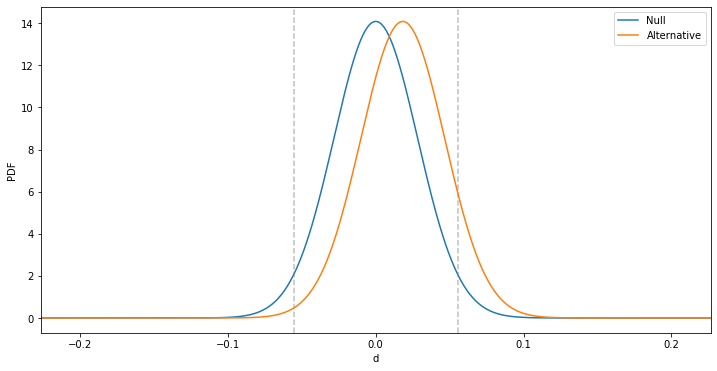

In [178]:
n = c_total, e_total
bcr = c_rate  
d_hat = e_rate - c_rate
abplot(c_total, e_total, bcr, d_hat)

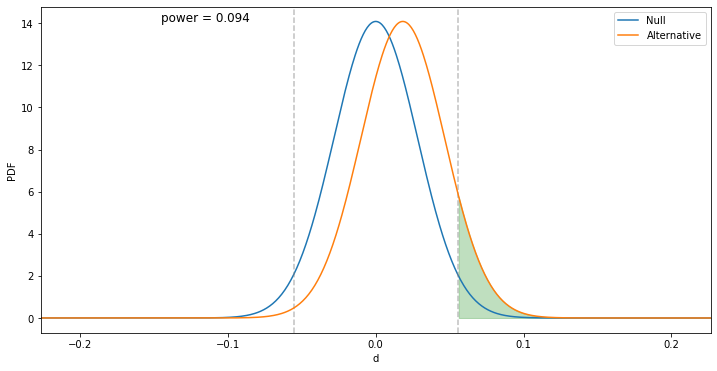

In [181]:
abplot(c_total, e_total, bcr, d_hat, show_power=True)

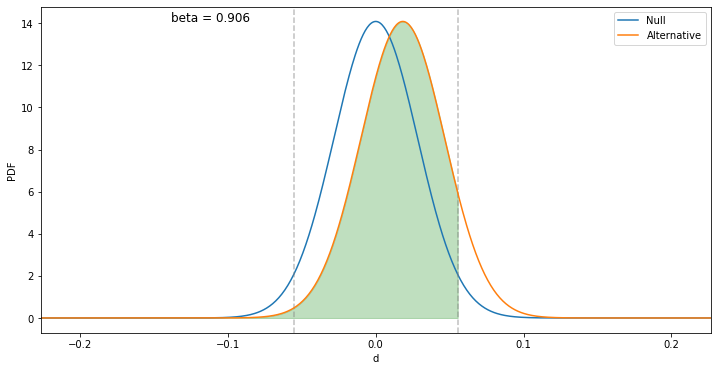

In [182]:
abplot(c_total, e_total, bcr, d_hat, show_beta=True)

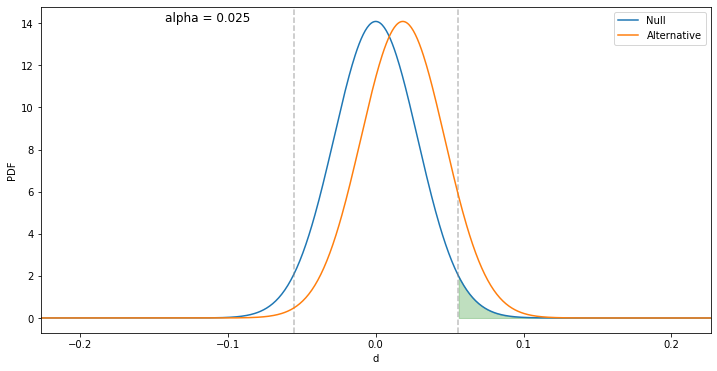

In [183]:
abplot(c_total, e_total, bcr, d_hat, show_alpha=True)

In [188]:
min_sample_size(power=0.094, bcr=bcr, mde=d_hat)

615.0875830803041

In [ ]:
abplot(c_total, e_total, bcr, d_hat, show_beta=True)

In [ ]:
abplot(c_total, e_total, bcr, d_hat, show_beta=True)